<a href="https://colab.research.google.com/github/Song-z-h/data-intensive-proj/blob/master/recomendation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Progetto: Book Recommendation

**Programmazione di Applicazioni Data Intensive**  
Laurea in Ingegneria e Scienze Informatiche  
DISI - Università di Bologna, Cesena

zhaohui.song@studio.unibo.it  giuseppe.pintus2@studio.unibo.it


In [843]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


dataset
https://www.kaggle.com/code/sercanyesiloz/book-recommendation-system/input?select=Books+Data+with+Category+Language+and+Summary

In order to import the dataset, you should downlaod the dataset, and load it to this notebook, then change the url path to load the dataset, you can find the code below

### Project objective

We have a dataset of books, users, and the ratings to these books given by users, and we want to predict user ratings and give recomendations

Contributions:
- Analysis of our user, examine the quality of their ratings
- Individual potential bias in the collected data and outliers
- Hands on the ulity matrix, and coduct k-nn parameter search
- Test several recomendation systems for our book dataset using surprise
- Test the probabilistic recomendation model
- Analysis of comparision between different benchmarks (rmse, mse)
- 2 ways to give recomendation

# Importation data & libraries

In [844]:
import os
import numpy as np
import pandas as pd

import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
%matplotlib inline
import gc

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics import euclidean_distances
from scipy.spatial.distance import cdist

import warnings
warnings.filterwarnings("ignore")

In [845]:
import zipfile

#substitute this path with the path in your drive, or just load the zip file
with zipfile.ZipFile('drive/MyDrive/dataintensive/archive.zip', 'r') as zip_ref:
    zip_ref.extractall('data')


In [846]:
import pandas as pd

df = pd.read_csv('data/Preprocessed_data.csv')

# Data Description

This dataset contains 278,858 users (anonymized but with demographic information) providing 1,149,780 ratings (explicit / implicit) about 271,379 books.

## General data description

In [847]:
df.head(5)

,Unnamed: 0,user_id,location,age,isbn,rating,book_title,book_author,year_of_publication,publisher,img_s,img_m,img_l,Summary,Language,Category,city,state,country
0,0,2,"stockton, california, usa",18.0000,0195153448,0,Classical Mythology,Mark P. O. Morford,2002.0,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,Provides an introduction to classical myths pl...,en,['Social Science'],stockton,california,usa
1,1,8,"timmins, ontario, canada",34.7439,0002005018,5,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,"In a small town in Canada, Clara Callan reluct...",en,['Actresses'],timmins,ontario,canada
2,2,11400,"ottawa, ontario, canada",49.0000,0002005018,0,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,"In a small town in Canada, Clara Callan reluct...",en,['Actresses'],ottawa,ontario,canada
3,3,11676,"n/a, n/a, n/a",34.7439,0002005018,8,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,"In a small town in Canada, Clara Callan reluct...",en,['Actresses'],NaN,NaN,NaN
4,4,41385,"sudbury, ontario, canada",34.7439,0002005018,0,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,"In a small town in Canada, Clara Callan reluct...",en,['Actresses'],sudbury,ontario,canada


## We have mixed unprocessed data, but they can be divided into 2 main sections

### users
- user_id The unique id associated to the user
- location User's location as a string
- age The user's age
- rating A rating to a book
- city The city of the user
- state The state of the country where the user lives
- country The country of the user

### books

- isbn Unique Id associated to the book
- book_title The title of the book
- book_author The author of the book
- year_of_publication The year when the book was officially published
- publisher The publisher of the book
- img_s, img_l, img_m The cover image of the book
- Sumarry A description of the coentent
- Language The language the book was writen in


We checked the ratings count for each score.

In [848]:
rating_counts = df['rating'].value_counts().reset_index()
# Rename the columns for clarity
rating_counts.columns = ['rating', 'count']

# Sort the DataFrame by the "rating" column if needed
rating_counts = rating_counts.sort_values(by='rating')

# Print the result
print(rating_counts)

    rating   count
0        0  647323
10       1    1481
9        2    2375
8        3    5118
7        4    7617
5        5   45355
6        6   31689
3        7   66404
1        8   91806
4        9   60780
2       10   71227


This prints shows that a lot of user gave 0 score to the books, We are not sure if these data are fake, or the service is really that bad. For the sake of project, we do not explore the reason behind.

In [849]:
df.describe()

,Unnamed: 0,user_id,age,rating,year_of_publication
count,1.031175e+06,1.031175e+06,1.031175e+06,1.031175e+06,1.031175e+06
mean,5.155870e+05,1.405944e+05,3.642902e+01,2.839022e+00,1.995283e+03
std,2.976747e+05,8.052444e+04,1.035354e+01,3.854149e+00,7.309340e+00
min,0.000000e+00,2.000000e+00,5.000000e+00,0.000000e+00,1.376000e+03
25%,2.577935e+05,7.041500e+04,3.100000e+01,0.000000e+00,1.992000e+03
50%,5.155870e+05,1.412100e+05,3.474390e+01,0.000000e+00,1.997000e+03
75%,7.733805e+05,2.114260e+05,4.100000e+01,7.000000e+00,2.001000e+03
max,1.031174e+06,2.788540e+05,9.900000e+01,1.000000e+01,2.008000e+03


From this graph, we can see that the average age of our users are 36 years old, and the average rating is 2.83.

## Users description

### Data distribution

The objective of this section is to provide meanings to the user distribution.

In [850]:
user_df = df[["user_id", "city", "state", "country", "age"]]
user_df.head(5)

,user_id,city,state,country,age
0,2,stockton,california,usa,18.0000
1,8,timmins,ontario,canada,34.7439
2,11400,ottawa,ontario,canada,49.0000
3,11676,NaN,NaN,NaN,34.7439
4,41385,sudbury,ontario,canada,34.7439


Most of the users come from NA.

In [851]:
country_counts = user_df["country"].value_counts()
country_counts

usa                     745840
canada                   92957
united kingdom           32011
germany                  27655
australia                18217
                         ...  
victoria, australia          1
lebanon                      1
x                            1
china"                       1
päijät-häme, finland         1
Name: country, Length: 414, dtype: int64

We drop the outliers like those who comes from like `x` or `china"`, only keeping those with more than 1000 ratings per country

In [852]:
filtered_country_counts = country_counts[country_counts >= 1000]

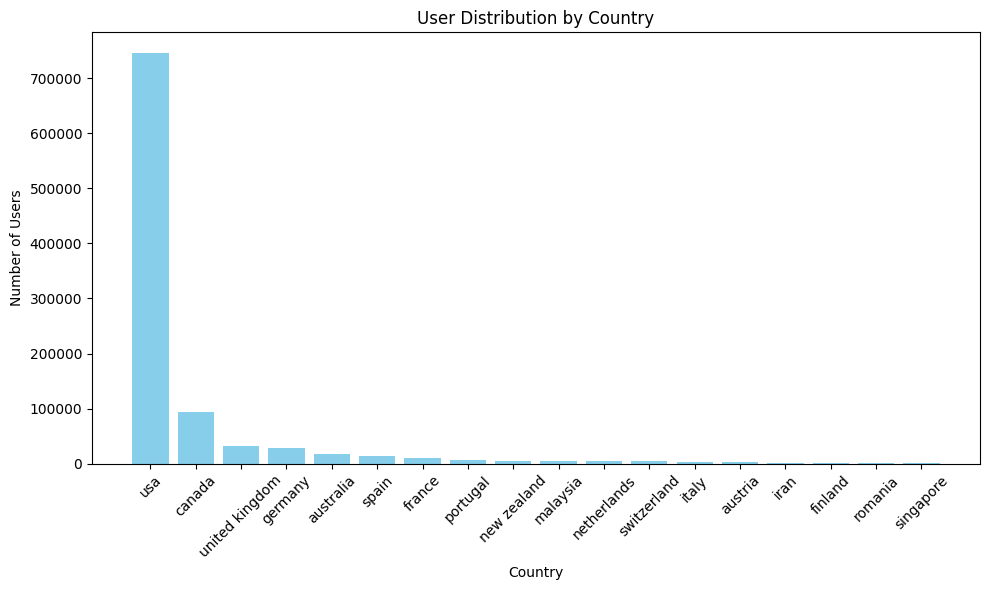

In [853]:
# Create a histogram chart
plt.figure(figsize=(10, 6))
plt.bar(filtered_country_counts.index, filtered_country_counts.values, color='skyblue')
plt.xlabel('Country')
plt.ylabel('Number of Users')
plt.title('User Distribution by Country')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()

# Show the histogram
plt.show()

This graph shows that most of the book ratings come from North America users, we need to be aware that if we used this data to generate predictions for an user who comes from a rare country, it might be not accurate, thus potentially biased

<Axes: title={'center': 'Age'}, ylabel='Frequency'>

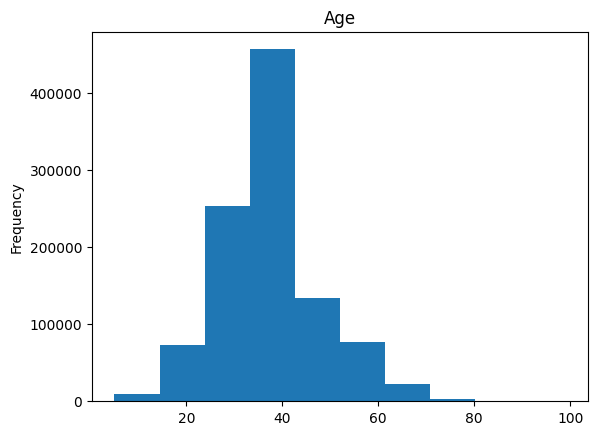

In [854]:
user_df["age"].plot(kind = 'hist', title = 'Age')

Most of the users are aged between 20 and 60 years old.

### Data quality

This section provides an analysis on the quality of ratings provided by the users

In [855]:
user_df = df[["user_id", "country", "age", "rating"]]

In [856]:
user_df

,user_id,country,age,rating
0,2,usa,18.0000,0
1,8,canada,34.7439,5
2,11400,canada,49.0000,0
3,11676,NaN,34.7439,8
4,41385,canada,34.7439,0
...,...,...,...,...
1031170,278851,usa,33.0000,0
1031171,278851,usa,33.0000,5
1031172,278851,usa,33.0000,7
1031173,278851,usa,33.0000,7


In [857]:
user_df.describe()

,user_id,age,rating
count,1.031175e+06,1.031175e+06,1.031175e+06
mean,1.405944e+05,3.642902e+01,2.839022e+00
std,8.052444e+04,1.035354e+01,3.854149e+00
min,2.000000e+00,5.000000e+00,0.000000e+00
25%,7.041500e+04,3.100000e+01,0.000000e+00
50%,1.412100e+05,3.474390e+01,0.000000e+00
75%,2.114260e+05,4.100000e+01,7.000000e+00
max,2.788540e+05,9.900000e+01,1.000000e+01


In [858]:
print("number of ratings", len(user_df))
print("number of users", user_df["user_id"].nunique())
print("number of countries", user_df["country"].nunique())
print("average number of ratings", user_df["user_id"].value_counts().mean())
print("average rating", user_df["rating"].mean())

number of ratings 1031175
number of users 92107
number of countries 414
average number of ratings 11.19540317239732
average rating 2.8390215045942737


We want to know per single user, what is the average rating given by him, and what is the rating counts. We will create a new dataframe with these 2 additional columns.

In [859]:
user_num_ratings = df.groupby('user_id')['rating'].count().reset_index()
user_num_ratings.columns = ['user_id', 'num_ratings']

In [860]:
user_avg_rating = df.groupby('user_id')['rating'].mean().reset_index()
user_avg_rating.columns = ['user_id', 'avg_rating']

In [861]:
user_df = user_df.drop('rating', axis=1)

In [862]:
user_df = user_df.drop_duplicates()
user_df

,user_id,country,age
0,2,usa,18.0000
1,8,canada,34.7439
2,11400,canada,49.0000
3,11676,NaN,34.7439
4,41385,canada,34.7439
...,...,...,...
1031143,278636,usa,34.7439
1031149,278659,usa,33.0000
1031151,278713,usa,63.0000
1031152,278714,usa,34.7439


In [863]:
merged_df = pd.merge(user_df, user_num_ratings, on='user_id', how='left')
merged_df = pd.merge(merged_df, user_avg_rating, on='user_id', how='left')
merged_df

,user_id,country,age,num_ratings,avg_rating
0,2,usa,18.0000,1,0.000000
1,8,canada,34.7439,17,2.294118
2,11400,canada,49.0000,62,2.000000
3,11676,NaN,34.7439,11144,4.582645
4,41385,canada,34.7439,10,0.000000
...,...,...,...,...,...
92102,278636,usa,34.7439,1,5.000000
92103,278659,usa,33.0000,1,10.000000
92104,278713,usa,63.0000,1,8.000000
92105,278714,usa,34.7439,1,0.000000


As you can see, this table has 2 agumented columns that displays the quality of each user account.

We drop those users who rated less than 3 times.

In [864]:
threshold = 3  # Adjust this threshold as needed
filtered_df_new = merged_df[merged_df['num_ratings'] >= threshold]

In [865]:
filtered_df_new

,user_id,country,age,num_ratings,avg_rating
1,8,canada,34.7439,17,2.294118
2,11400,canada,49.0000,62,2.000000
3,11676,NaN,34.7439,11144,4.582645
4,41385,canada,34.7439,10,0.000000
5,67544,canada,30.0000,12,5.000000
...,...,...,...,...,...
91739,261160,spain,39.0000,5,7.400000
91809,265051,spain,40.0000,3,4.666667
91891,268180,usa,71.0000,3,5.000000
92068,276442,switzerland,62.0000,3,6.333333


Since there are a lot of typo on the contries, we have many unsensical country names. To this end, we try to plot the top k country on the chart.

In [866]:
k = 10
filtered_df = filtered_df_new[filtered_df_new['country'] != 'usa']
filtered_df = filtered_df[filtered_df['country'] != 'canada']

country_rating_counts = filtered_df['country'].value_counts().reset_index()
country_rating_counts.columns = ['country', 'rating_count']
top_k_countries = country_rating_counts.sort_values(by='rating_count', ascending=False).head(k)
top_k_countries


,country,rating_count
0,germany,1505
1,united kingdom,1156
2,australia,653
3,spain,617
4,france,340
5,italy,251
6,switzerland,215
7,portugal,204
8,netherlands,188
9,new zealand,149


In [867]:
filtered_df = filtered_df[filtered_df['country'].isin(top_k_countries['country'])]
filtered_df.head(5)

,user_id,country,age,num_ratings,avg_rating
62,24539,spain,34.7439,135,0.000000
65,189238,new zealand,34.7439,3,2.000000
76,213915,united kingdom,29.0000,105,1.352381
95,13582,portugal,29.0000,168,2.916667
115,29654,germany,42.0000,6,4.833333


We plot the relationship between age and average ratings.

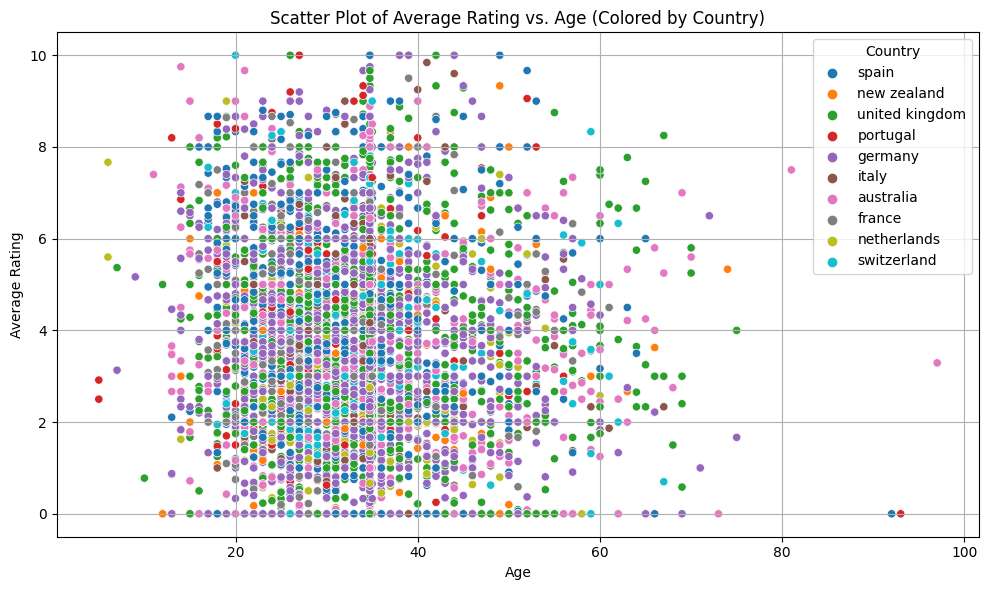

In [868]:
# Create a scatter plot with 'country' as the color feature using Seaborn
plt.figure(figsize=(10, 6))
sns.scatterplot(x='age', y='avg_rating', hue='country', data=filtered_df, palette='tab10')
plt.xlabel('Age')
plt.ylabel('Average Rating')
plt.title('Scatter Plot of Average Rating vs. Age (Colored by Country)')
plt.grid(True)
plt.legend(title='Country', loc='upper right')
plt.tight_layout()

# Show the plot
plt.show()

Some users have the rating average of zero, if they rated zero to all books they received, that will be a problem. From this analysis, we can recomend more books to the users who gave a high average score; and provide more services and feedbacks from those users who gave a low average score.

Now we plot the correlation between rating counts and the age.

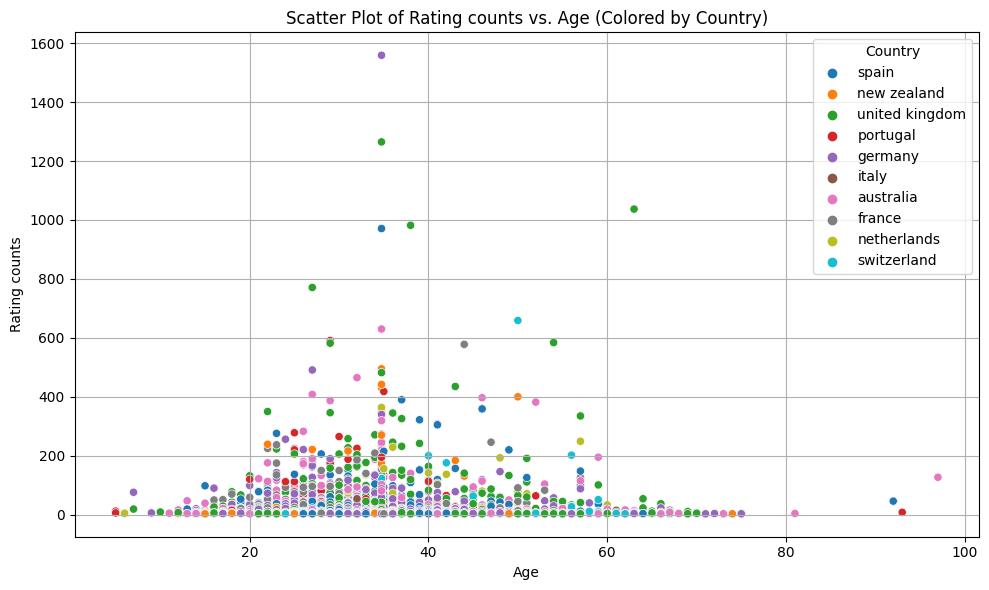

In [869]:
# Create a scatter plot with 'country' as the color feature using Seaborn
plt.figure(figsize=(10, 6))
sns.scatterplot(x='age', y='num_ratings', hue='country', data=filtered_df, palette='tab10')
plt.xlabel('Age')
plt.ylabel('Rating counts')
plt.title('Scatter Plot of Rating counts vs. Age (Colored by Country)')
plt.grid(True)
plt.legend(title='Country', loc='upper right')
plt.tight_layout()

# Show the plot
plt.show()

We can see that people ranging from age 20 and age 60 contributed the most to our dataset. Then teenagers rated a bit less. Lastly, people aging more than 60 rarely rated. That means when we try to give recomendations to elderly, we might compute the similarity between them with the middle aged people. And I don't think there are similarities at all between elderly and teenages. But this should be verified.

# Data exploration with utility matrix

In this section, we try to manipolate the data in the form of matrix, and process the dataset.

## Extracting utility matrix

### Debiasing method

As we see in the data exploration section, most of the users who provided data were NA users, it may be biased if we want to provide recomendation to other users who comes from rare regione.

For this reason, we can select k random ratings across all countries. Then we will have a fair dataset that is less biased.

In [870]:
ratings_df =df[["user_id","isbn","rating", "country"]]
ratings_df.head(5)

,user_id,isbn,rating,country
0,2,0195153448,0,usa
1,8,0002005018,5,canada
2,11400,0002005018,0,canada
3,11676,0002005018,8,NaN
4,41385,0002005018,0,canada


From the data shown above, we drop those who has average rating `0`, those who rated zero, but their average score is not will be kept.

In [871]:
# Calculate the average rating for each user
user_avg_rating = ratings_df.groupby('user_id')['rating'].mean().reset_index()

# Filter out users with an average rating of 0 and more than 1 rating
filtered_users = user_avg_rating[(user_avg_rating['rating'] != 0) & (user_avg_rating['rating'].notna())]

# Merge the filtered user list with the original ratings_df to get the filtered dataset
filtered_ratings_df = pd.merge(ratings_df, filtered_users, on='user_id', how='inner')

# Drop the extra rating column (the average rating)
filtered_ratings_df = filtered_ratings_df.drop(columns=['rating_y'])

# Rename the remaining rating column to 'rating'
ratings_df = filtered_ratings_df.rename(columns={'rating_x': 'rating'})
ratings_df

,user_id,isbn,rating,country
0,8,0002005018,5,canada
1,8,0060973129,0,canada
2,8,0374157065,0,canada
3,8,0393045218,0,canada
4,8,0399135782,0,canada
...,...,...,...,...
987544,278376,0060530103,7,usa
987545,278621,1550390961,8,canada
987546,278636,0375507299,5,usa
987547,278659,0345330293,10,usa


Then we randomly select k ratings from each country, and only counties of which has at least k ratings.

In [872]:
# Define the value of k
k = 300

# Group the ratings_df by 'country'
grouped = ratings_df.groupby('country')

# Initialize an empty list to store the selected data
selected_data = []

# Loop through each group (country)
for name, group in grouped:
    # Check if there are at least k users in the country
    if len(group) >= k:
        # Sort the group by 'rating' column in descending order and select the top k users
        top_k_users = group.head(k)
        # Append the selected data to the list
        selected_data.append(top_k_users)

# Create a new DataFrame by concatenating the selected data
result_df = pd.concat(selected_data)

# Reset the index of the result DataFrame
result_df.reset_index(drop=True, inplace=True)

# Print the result DataFrame
result_df

,user_id,isbn,rating,country
0,133706,0440234743,8,australia
1,133706,0380718332,8,australia
2,133706,0425163407,7,australia
3,133706,0440224764,7,australia
4,133706,0446605484,8,australia
...,...,...,...,...
8995,110912,0380764008,0,usa
8996,110912,031242227X,9,usa
8997,110912,1853261092,0,usa
8998,110912,0439313899,0,usa


In [873]:
ratings = result_df.drop(columns=['country'])

### Max rating counts method

You can select this method to create a different dataset, the difference between this `max rating counts method` and `debiasing method` is that, this methods tries to contain users with more ratings, that makes the matrix more populated; In the mean while, the debiasing method provides a general dataset to reduce biases in the valuation.

In [874]:
#set_size=200000
#ratings = df[:set_size]
#ratings = ratings_df

In [875]:
#Don't comment this, because to work with matrix, we need to unstack the dataframe
ratings.set_index(["user_id", "isbn"], inplace=True)
ratings = ratings["rating"].unstack("isbn").astype(pd.SparseDtype("float", np.nan))
#ratings['count_non_null'] = ratings.count(axis=1)

In [876]:
'''
# Sort by 'count_non_null' in descending order
sorted_ratings = ratings.sort_values(by='count_non_null', ascending=False)

# Take the top 200 rows
top_200_ratings = sorted_ratings.head(2)

# Drop the 'count_non_null' column
top_200_ratings = top_200_ratings.drop(columns=['count_non_null'])

# Create a new matrix (numpy array) from the top 200 rows
ratings = top_200_ratings'''

"\n# Sort by 'count_non_null' in descending order\nsorted_ratings = ratings.sort_values(by='count_non_null', ascending=False)\n\n# Take the top 200 rows\ntop_200_ratings = sorted_ratings.head(2)\n\n# Drop the 'count_non_null' column\ntop_200_ratings = top_200_ratings.drop(columns=['count_non_null'])\n\n# Create a new matrix (numpy array) from the top 200 rows\nratings = top_200_ratings"

In [877]:
ratings.head(5)

isbn,0001935968,000195833X,0002005018,0002005050,0002160595,0002215497,0002233711,0002243954,0002244098,0002550563,...,9810455674,9813068612,9971640147,9971655292,997951079X,9995585227,B000051ZUO,B00005BBW4,B00005NCS7,B000069F44
user_id,,,,,,,,,,,,,,,,,,,,,
8,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
212,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
626,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
901,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1461,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### K nearest neighbour similarity matrix

In [878]:
R = ratings.fillna(0).values
R[:5, :5]

array([[0., 0., 5., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]])

In [879]:
P = ratings.notna().values
P[:5, :5]

array([[False, False,  True, False, False],
       [False, False, False, False, False],
       [False, False, False, False, False],
       [False, False, False, False, False],
       [False, False, False, False, False]])

Extracting useful information from the matrix `P` and `R`.

In [880]:
print("number of ratings:", P.sum())
print("number of users who has rated a book", P.shape[0])
print("number of books: ", P.shape[1])
print("average ratings from users: ", R.mean(where=P))
print("average rate of rating: ", P.sum()/P.shape[0])

print("the maximum numbers of ratings given by an user: ",P.sum(1).max())
print("the book with minimum number of ratings: ", P.sum(0).min())

number of ratings: 9000
number of users who has rated a book 209
number of books:  7248
average ratings from users:  3.127
average rate of rating:  43.0622009569378
the maximum numbers of ratings given by an user:  300
the book with minimum number of ratings:  1


In [881]:
isbn = ratings.columns[P.sum(0).argmax()]
book_name = df[df['isbn'] == isbn]['book_title']
print("the book name with maximum number of ratings:")
book_name.head(1)

the book name with maximum number of ratings:


769    Wild Animus
Name: book_title, dtype: object

In [882]:
print("5 books with the most average rating:")
indexes = (-R.mean(0, where=P)).argsort()[:5]
book_isbns = ratings.columns[indexes]
#book_with_most_rating_names = [df[df['isbn'] == name]['book_title'] for name in book_isbns]
book_isbns

5 books with the most average rating:


Index(['0001935968', '0380012057', '8472236552', '1851452052', '0380017962'], dtype='object', name='isbn')

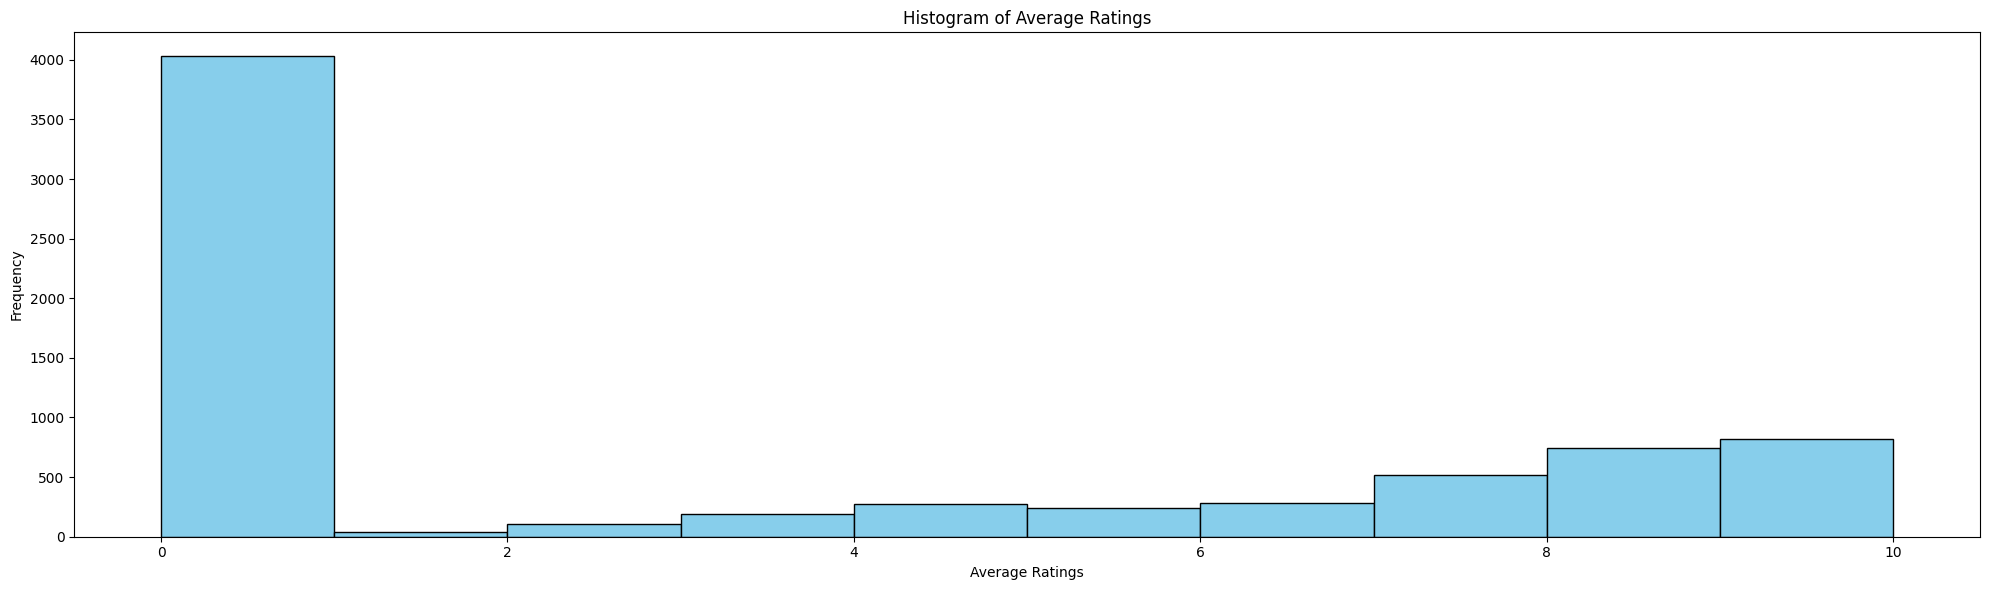

In [883]:
most_rated_books_average_ratings = -np.sort((-R.mean(0, where=P)))
plt.figure(figsize=(20, 6))
plt.hist(most_rated_books_average_ratings, bins=10, color='skyblue', edgecolor='black')
plt.xlabel('Average Ratings')
plt.ylabel('Frequency') # the number of book that share the same average rating score
plt.title('Histogram of Average Ratings')
plt.tight_layout()
plt.show()

Ram space cleanning up

# Data preparation

## Prepare training set and validation set

In [884]:
print(ratings.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 209 entries, 8 to 277478
Columns: 7248 entries, 0001935968 to B000069F44
dtypes: Sparse[float64, nan](7248)
memory usage: 107.1 KB
None


In [885]:
division_index=int(0.9*ratings.shape[0])
val_set = ratings.sparse.to_dense()

In [886]:
# Convertiamo il DataFrame sparsa in uno denso
dense_ratings = ratings.sparse.to_dense()

train_set = pd.DataFrame(index=dense_ratings.index, columns=dense_ratings.columns)
train_set[:] = np.nan

# Itera sulle righe
for index, row in dense_ratings.iterrows():
    non_nan_indices = row.dropna().index
    if len(non_nan_indices) == 1:
        train_set.at[index, non_nan_indices[0]] = dense_ratings.at[index, non_nan_indices[0]]
    else:
        num_samples = len(non_nan_indices)
        train_samples_idx = np.random.choice(num_samples, size=int(0.8 * num_samples), replace=False)
        selected_indices = [non_nan_indices[i] for i in train_samples_idx]
        for j in selected_indices:
            train_set.at[index, j] = dense_ratings.at[index, j]

# Converti nuovamente in sparsa
train_set = train_set.astype(pd.SparseDtype("float", np.nan))


In [887]:
del dense_ratings
gc.collect()

11004

In [888]:
val_set.iloc[:3, :15]

isbn,0001935968,000195833X,0002005018,0002005050,0002160595,0002215497,0002233711,0002243954,0002244098,0002550563,0002558122,0002711567,0004483642,0004586298,0004586654
user_id,,,,,,,,,,,,,,,
8,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
212,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
626,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [889]:
train_set.iloc[:3, :15]

isbn,0001935968,000195833X,0002005018,0002005050,0002160595,0002215497,0002233711,0002243954,0002244098,0002550563,0002558122,0002711567,0004483642,0004586298,0004586654
user_id,,,,,,,,,,,,,,,
8,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
212,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
626,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [890]:
val_set.shape == train_set.shape

True

In [891]:
val_set = val_set.reindex_like(train_set)

In [892]:
np.array_equal(train_set.index, val_set.index)

True

In [893]:
np.array_equal(train_set.columns, val_set.columns)

True

In [894]:
R_train = train_set.fillna(0).values
P_train = train_set.notna().values

R_val = val_set.fillna(0).values
P_val = val_set.notna().values

In [895]:
val_actual = R_val[P_val]

# Prediction without models

## Collaborative prediction

Similarity calculation between an user `a` and an user `b` over item `i`:
$$ \text{sim}(u,v) = \frac{\sum_{i\in C_{u,v}} r_{u,i}\cdot r_{v,i}}{\sqrt{\sum_{i\in C_{u,v}} r_{u,i}^2}\cdot\sqrt{\sum_{i\in C_{u,v}} r_{v,i}^2}}$$

In [896]:
R = R_train
P = P_train
print(R.shape, P.shape) # = M X N
# Where M is the number of users and N is the number of items

(209, 7248) (209, 7248)


if i want to get the cos similarity bewteen users (m x n) @ (n x m) = (m x m) which is (user_dim x user_dim)

In [897]:
sim_numerator = R @ R.T
sim_numerator.shape

(209, 209)

In order to calculate the denominator, we need the norm of the scores between a pair of users, and we will only take the scores where the matrix P shows `True`

In [898]:
# a vector of dimension m x m x n, that is (user, user, boolean)
# we have m x n,  so we need to add 1 dimension to m
# that can be (1, m, n) and (m, 1, n)
P_rated = P[None, :, :] & P[:, None, :]
P_rated.shape

(209, 209, 7248)

Now we need a 3d vector of dimension (m x m x n), that is (user, user, score), this matrix contains information about ratings of items only if the item is rated by both users

In [899]:
#(m x m x n) * (1, m, n) = (m, m, n)
R_both_rated = P_rated * R
R_both_rated.shape
# although in this case, we have (m,m,n), but the score
#will be of the user in the second dimension(dim=1) in the 3d array (_, m, _)

(209, 209, 7248)

Now we can calculate the normalization of the denominator

In [900]:
R_both_rated_norm = np.linalg.norm(R_both_rated, axis=2)
#axis = 2 because that is the dimension where rating is saved
R_both_rated_norm.shape

(209, 209)

Then, we get the square of the values of the matrix
$${\sqrt{\sum_{i\in C_{u,v}} r_{u,i}^2}\cdot\sqrt{\sum_{i\in C_{u,v}} r_{v,i}^2}}$$

In [901]:
similarity_denominator = R_both_rated_norm * R_both_rated_norm.T
similarity_denominator.shape

(209, 209)

In [902]:
cosin_sim = sim_numerator / similarity_denominator
cosin_sim[:5, :5]

array([[ 1., nan, nan, nan, nan],
       [nan,  1., nan, nan, nan],
       [nan, nan,  1., nan, nan],
       [nan, nan, nan,  1., nan],
       [nan, nan, nan, nan,  1.]])

We replace nan with the value zero

In [903]:
cosin_sim = np.where(np.isnan(cosin_sim), 0, cosin_sim)
cosin_sim[:50, :50]

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

When we have a sparse matrix, this would not work so well.

Now we can test this method on our validation dataset

In [904]:
def get_val_predictions(pred_func, k):
    return np.array([
        pred_func(u, i, k)
        for u, i in zip(*P_val.nonzero())
    ])

In [905]:
def RMSE(actual, predicted):
    return np.sqrt(np.mean(np.square(predicted - actual)))

In [906]:
def predict_from_neighbors(u, i, k):
    voters = list(P[:, i].nonzero()[0])
    voters.sort(key=lambda x: cosin_sim[u, x], reverse=True)
    voters = voters[:k]
    predicted_vote = (cosin_sim[u, voters] @ R[voters, i]) / cosin_sim[u, voters].sum()
    return predicted_vote if not np.isnan(predicted_vote) else R[P].mean()

In [907]:
K_similar_users = 1

In [908]:
k_sim_mserr = [RMSE(val_actual, get_val_predictions(predict_from_neighbors, k)) for k in range(K_similar_users)]

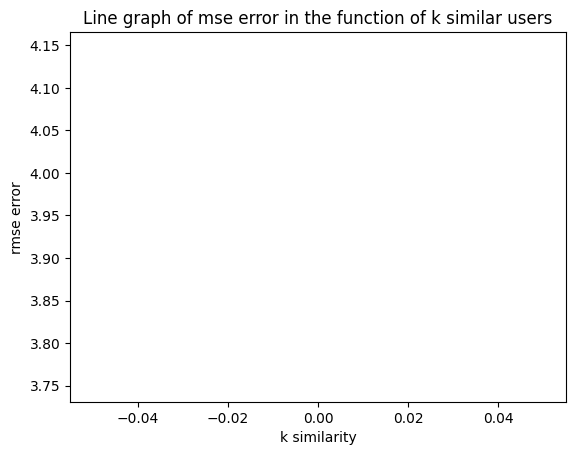

In [909]:
plt.title("Line graph of mse error in the function of k similar users")
plt.xlabel("k similarity")
plt.ylabel("rmse error")
plt.plot(np.arange(K_similar_users), k_sim_mserr, color ="red")
plt.show()

From this chart, we can see that there is no neccessary that we need to compute the similarity among all users, but just 3 is enough.

In [910]:
print(P.shape[0])

209


In [911]:
val_predictions = get_val_predictions(predict_from_neighbors, P.shape[0])
RMSE(val_actual, val_predictions)

1.9705953538833687

In [912]:
val_predictions = get_val_predictions(predict_from_neighbors, 3)
RMSE(val_actual, val_predictions)

1.967692412920151

# Prediction with models

## Bayesian model


In [913]:
def percentile_of_non_nan(matrix):
    # Count non-NaN values
    non_nan_count = np.sum(~np.isnan(matrix))

    # Total number of elements in the matrix
    total_elements = matrix.size

    # Compute the percentile
    percentile = (non_nan_count / total_elements) * 100
    return percentile

In [914]:
def bayesian_recommendation(matrix, user_vector):
    num_books = matrix.shape[1]

    best_ratings_for_user = []

    # 1. Identifica gli articoli/libri per cui l'utente di riferimento ha dato una valutazione
    rated_by_user = ~np.isnan(user_vector)

    # 2. Filtra gli utenti che hanno votato gli stessi libri dell'utente target
    similar_users_mask = ~np.isnan(matrix[:, rated_by_user]).all(axis=1)
    filtered_matrix = matrix[similar_users_mask]

    for i in range(num_books):
        # Se l'utente ha già valutato il libro, saltalo
        if not np.isnan(user_vector[i]):
            best_ratings_for_user.append(user_vector[i])
            continue

        best_rating_for_book = None
        best_prob = -np.inf  # inizializziamo a un valore molto basso

        # Calcola la probabilità a priori per ogni rating per il libro corrente
        unique_ratings, counts = np.unique(filtered_matrix[:, i][~np.isnan(filtered_matrix[:, i])], return_counts=True)
        total_ratings = np.sum(counts)
        p_y = dict(zip(unique_ratings, counts / total_ratings))

        for rating in range(11):  # 0-10 ratings
            # Calcola una versione semplificata di P(X|Y=rating)
            p_x_given_y = np.nanmean(filtered_matrix[:, i] == rating)

            # Calcola P(Y=rating|X) come P(X|Y) * P(Y)
            p_y_given_x = p_x_given_y * p_y.get(rating, 0)

            if p_y_given_x > best_prob:
                best_prob = p_y_given_x
                best_rating_for_book = rating

        best_ratings_for_user.append(best_rating_for_book)

    return best_ratings_for_user


In [915]:
matrix = train_set.to_numpy()
user_matrix =val_set.to_numpy()
predicted_matrix = train_set.to_numpy()

In [916]:
#test
#matrix.shape[0]
np.array(bayesian_recommendation(matrix, user_matrix[0])).shape

(7248,)

In [917]:
def RMSE(actual, predicted):
    mask = ~np.isnan(actual)
    actual_filtered = actual[mask]
    predicted_filtered = predicted[mask]
    return np.sqrt(np.mean(np.square(predicted_filtered - actual_filtered)))

In [918]:
predicted_matrix.shape

(209, 7248)

In [919]:
percentile_of_non_nan(matrix)

0.4705472289996514

In [920]:
'''for user_idx in range(matrix.shape[0]):
    # Clone user ratings from training set
    user_ratings = matrix[user_idx].copy()
    # Get predicted ratings for the user
    predictions = bayesian_recommendation(matrix, user_ratings)

    # Update the predicted_matrix with modified ratings
    predicted_matrix[user_idx] = np.array(predictions)

total_rmse = RMSE(user_matrix,predicted_matrix)
print("RMSE between validation and predicted matrices:", total_rmse)'''

'for user_idx in range(matrix.shape[0]):\n    # Clone user ratings from training set\n    user_ratings = matrix[user_idx].copy()\n    # Get predicted ratings for the user\n    predictions = bayesian_recommendation(matrix, user_ratings)\n\n    # Update the predicted_matrix with modified ratings\n    predicted_matrix[user_idx] = np.array(predictions)\n\ntotal_rmse = RMSE(user_matrix,predicted_matrix)\nprint("RMSE between validation and predicted matrices:", total_rmse)'

## User based filtering

In [921]:
k = 10

In [922]:
!pip install scikit-surprise

In [923]:
train_set_stacked = train_set.stack()
train_set_stacked = train_set_stacked.reset_index()

train_set_stacked = train_set.stack()
train_set_stacked = train_set_stacked.reset_index()

val_set_stacked = val_set.stack()
val_set_stacked = val_set_stacked.reset_index()


In [924]:
from surprise import Dataset
from surprise import Reader
from surprise.dataset import DatasetAutoFolds

reader = Reader(rating_scale=(1e-5, 10))

train_dataset = Dataset.load_from_df(train_set_stacked, reader)
train_dataset = pd.DataFrame(train_dataset.__dict__['raw_ratings'], columns=['user_id','item_id','rating','timestamp'])
train_dataset[train_dataset["rating"] == 0] = 1e-5
train_dataset = train_dataset.drop(columns=["timestamp"])
train_dataset = Dataset.load_from_df(train_dataset, reader)

val_dataset = Dataset.load_from_df(val_set_stacked, reader)
val_dataset = pd.DataFrame(val_dataset.__dict__['raw_ratings'], columns=['user_id','item_id','rating','timestamp'])
val_dataset[val_dataset["rating"] == 0] = 1e-5
val_dataset = val_dataset.drop(columns=["timestamp"])
val_dataset = Dataset.load_from_df(val_dataset, reader)


In [925]:
trainset = train_dataset.build_full_trainset()
valset = val_dataset.build_full_trainset().build_testset()

### KNN

In [926]:
from surprise import KNNBasic
model = KNNBasic(k=trainset.n_users, sim_options={"name": "cosine"})

In [927]:
model.fit(trainset)

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [928]:
model.sim[:4, :4]

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]])

In [929]:
from surprise.accuracy import rmse
from surprise.accuracy import mae

In [930]:
preds = model.test(valset)
rmse(preds), mae(preds)

RMSE: 1.4147
MAE:  0.4251


(1.4147464033586699, 0.4250901388233137)

In [931]:
user0 = ratings.index[0]
item0 = ratings.columns[0]
pred = model.predict(user0, item0)
pred

Prediction(uid=8, iid='0001935968', r_ui=None, est=3.1348263804713805, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

### Pearson

In [932]:
model = KNNBasic(k=10, sim_options={"name": "pearson"})
model.fit(trainset)
preds = model.test(valset)
rmse(preds), mae(preds)

Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.4113
MAE:  0.3884


(1.411282575170633, 0.3883564507367323)

### Kmeans

In [933]:
from surprise import KNNWithMeans
model = KNNWithMeans(k=10, sim_options={"name": "cosine"})
model.fit(trainset)
preds = model.test(valset)
rmse(preds), mae(preds)

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.3387
MAE:  0.3875


(1.338725961152107, 0.38752237997083966)

## Item based

In [934]:
model = KNNBasic(k=10, sim_options={"name": "cosine", "user_based": False})
model.fit(trainset)
preds = model.test(valset)
rmse(preds), mae(preds)

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.6093
MAE:  0.7160


(1.6092525189102818, 0.7160299101110955)

## svd

In [935]:
from surprise import SVD
model = SVD(n_factors=10, random_state=42)
model.fit(trainset)
preds = model.test(valset)
rmse(preds), mae(preds)

RMSE: 1.0570
MAE:  0.5226


(1.0570021925718545, 0.522572502421279)

In [936]:
user0 = ratings.index[0]
item0 = ratings.columns[0]

In [937]:
model.predict(user0, item0)

Prediction(uid=8, iid='0001935968', r_ui=None, est=4.203669592653451, details={'was_impossible': False})

## Random recomendation

In [938]:
from surprise import NormalPredictor
model = NormalPredictor()
model.fit(trainset)
preds = model.test(valset)
rmse(preds), mae(preds)

RMSE: 5.0391
MAE:  4.0421


(5.039086573830483, 4.042134854907451)

## Cross validation k-fold


In [939]:
from surprise.model_selection import KFold
kf = KFold(n_splits=3, shuffle=True, random_state=42)

In [940]:
from surprise.model_selection import cross_validate
model = KNNBasic(k=10, sim_options={"name": "cosine"})
cv_results = cross_validate(model, train_dataset, cv=kf)

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.


In [941]:
pd.DataFrame(cv_results)

,test_rmse,test_mae,fit_time,test_time
0,3.009424,1.766631,0.110204,1.668610
1,3.131796,1.871709,0.112192,1.656412
2,3.153153,1.920872,0.108161,1.592792


In [942]:
cv_results["test_rmse"].mean()

3.098124500937948

## Grid Search

In [943]:
from surprise.model_selection import GridSearchCV

In [944]:
grid = {
    "k": [5, 10, 20],
    "sim_options": {"name": ["cosine", "pearson"]}
}

In [945]:
grid = {"n_factors": range(1, 20, 1)}
gs = GridSearchCV(SVD, grid, cv=kf, refit=True)
gs.fit(train_dataset)

In [946]:
gs.best_params["rmse"]["n_factors"]

1

In [947]:
preds = gs.test(valset)
rmse(preds), mae(preds)

RMSE: 1.0849
MAE:  0.5373


(1.0849355625206445, 0.5373427440071887)

## Recomendations to the user


In [948]:
target_user = 0

In [949]:
preds = [
    gs.predict(target_user, trainset.to_raw_iid(ii))
    for ii in range(trainset.n_items)
]

In [950]:
# 8a
for p in sorted(preds, key=lambda p: p.est, reverse=True)[:10]:
  isbn = p.iid
  book_title = df[df['isbn'] == isbn]['book_title'].values[0]
  print(isbn, book_title)


0446310786 To Kill a Mockingbird
0439136369 Harry Potter and the Prisoner of Azkaban (Book 3)
043935806X Harry Potter and the Order of the Phoenix (Book 5)
0452264464 Beloved (Plume Contemporary Fiction)
0316666343 The Lovely Bones: A Novel
0060977493 The God of Small Things
0452282152 Girl with a Pearl Earring
0385504209 The Da Vinci Code
3492207006 Die Entdeckung der Langsamkeit.
0330267388 Life,the Universe and Everything


## Content based

In [951]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from PIL import Image

In [952]:
def content_based_recommender(book_title):

    book_title = str(book_title)
    if book_title in df['book_title'].values:
        rating_counts = pd.DataFrame(df['book_title'].value_counts())
        rare_books = rating_counts[rating_counts['book_title'] <= 100].index
        common_books = df[~df['book_title'].isin(rare_books)]

        if book_title in rare_books:

            random = pd.Series(common_books['book_title'].unique()).sample(2).values
            print('There are no recommendations for this book')
            print('Try: \n')
            print('{}'.format(random[0]),'\n')
            print('{}'.format(random[1]),'\n')

        else:

            common_books = common_books.drop_duplicates(subset=['book_title'])
            common_books.reset_index(inplace= True)
            common_books['index'] = [i for i in range(common_books.shape[0])]
            target_cols = ['book_title','book_author','publisher','Category']
            common_books['combined_features'] = [' '.join(common_books[target_cols].iloc[i,].values) for i in range(common_books[target_cols].shape[0])]
            cv = CountVectorizer()
            count_matrix = cv.fit_transform(common_books['combined_features'])
            cosine_sim = cosine_similarity(count_matrix)
            index = common_books[common_books['book_title'] == book_title]['index'].values[0]
            sim_books = list(enumerate(cosine_sim[index]))
            sorted_sim_books = sorted(sim_books,key=lambda x:x[1],
                                      reverse=True)[1:6]

            books = []
            for i in range(len(sorted_sim_books)):
                books.append(common_books[common_books['index'] == sorted_sim_books[i][0]]['book_title'].item())

            print(books)

    else:

        print('Cant find book in dataset, please check spelling')

In [953]:
book_title = df.iloc[1024, :]['book_title']
print("the book title is", book_title)
content_based_recommender(book_title)

the book title is Wild Animus
['Beloved (Plume Contemporary Fiction)', 'Bleachers', 'Neverwhere', 'Dreamcatcher', 'Choke']
